In [1]:
from cytoflow import *
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit
import math

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", { "xtick.major.size": 4, "ytick.major.size": 4, "font_color":'k', 'axes.edgecolor': 'k', 'xtick.color': 'k', 'ytick.color': 'k'})
sns.set_context("talk", font_scale=1.0)

In [2]:
plasmids = [74, 75, 76, 77, 78, 79, 
            80, 81, 82, 83, 84, 87,
            90, 91, 92, 93, 94, 96,
            97, 98, 99, 126, 217, 144]

In [3]:
plasmid_dict = { # maps plasmid number => plasmid name
#     57 : "ZIK1 KRAB + ZNF10 KRAB",    58 : "ZIK1 KRAB + FOXO3 TAD",
    59 : "ZIK1 KRAB + Rand Ctrl 89",  #60 : "KMT2C Dual + ZNF10 KRAB",
    61 : "KMT2C Dual + FOXO3 TAD",    #62 : "KMT2C Dual + Rand Ctrl 89",
    63 : "KMT2D Dual + ZNF10 KRAB",   #64 : "KMT2D Dual + FOXO3 TAD",
    65 : "KMT2D Dual + Rand Ctrl 89", 66 : "NCOA1 Dual + ZNF10 KRAB",
    67 : "NCOA1 Dual + FOXO3 TAD",    68 : "NCOA1 Dual + Rand Ctrl 89",
    69 : "NCOA2 Rep + FOXO3 TAD",     #70 : "Rand Ctrl + NCOA2 Act",
    #71 : "NCOA2 Rep + NCOA2 Act",     
    72 : "Rand Ctrl + Rand Ctrl 89",
    
    74 : "DMD - DMD",     75 : "DMD - RANDCTRL",      76 : "ZNF10 - ANM2",
    77 : "ZNF10 - CBX1",  78 : "RANDCTRL - RANDCTRL", 79 : "ANM2 - KIBRA",
    80 : "BIN1 - FOXO3",  81 : "CACO1 - ANM2",        82 : "CREM - MPP8",
    83 : "DPF1 - HSF2",   84 : "DPY30 - HXA13",       #85 : "FOXO3 - ZNF10",
    #86 : "IKKA - ANM2",   
    87 : "MPP8 - ZNF791", #88 : "MYBA - FOXO3",
    #89 : "NCOA2 - HXA13", 
    90 : "NOTC2 - ANM2",        91 : "NOTC2 - KIBRA",
    92 : "SMCA2 - U2AF4", 93 : "SUMO3 - SSX2",        94 : "YAF2 - ZNF791",
    #95 : "HES2 - NCOA2",  
    96 : "ATRX - HERC2",        97 : "SCML2 - NOTC2",
    98 : "CHD4 - CDYL2",  99 : "SMN2 - FOXO3",       
    
    126 : "rTetR only",  217 : "KRAB only",          144 : "MYBA only"
}

In [4]:
df = pd.read_csv('./data/all_cells_live_mch_gated.csv')
df = df[(df['P1'])&(df['mCherry'])]
df

,FSC 488/10-A,SSC 488/10-A,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,treatment,P1,mCherry
0,8.317540e+08,219492864.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,1.438797e+07,85923072.0,59,1.0,none,True,True
1,4.958666e+08,180896512.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,1.047672e+08,66599936.0,59,1.0,none,True,True
3,1.038254e+09,372244224.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,3.654259e+08,376630272.0,59,1.0,none,True,True
4,8.091105e+08,349765120.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,1.807135e+08,1863680.0,59,1.0,none,True,True
5,5.831183e+08,284132096.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,8.780590e+08,183085824.0,59,1.0,none,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5803242,8.637215e+08,205095936.0,5.0,MYB only,1000.0,2.147483e+09,4770816.0,144,2.0,none,True,True
5803243,9.044457e+08,298402560.0,5.0,MYB only,1000.0,3.455867e+08,230042112.0,144,2.0,none,True,True
5803245,9.663265e+08,209395712.0,5.0,MYB only,1000.0,4.253038e+08,17569536.0,144,2.0,none,True,True
5803246,5.636933e+08,185259520.0,5.0,MYB only,1000.0,1.603625e+08,231691776.0,144,2.0,none,True,True


In [5]:
counts = df.groupby(['plasmid', 'description', 'replicate', 'day', 'dox', 'treatment']).count().reset_index()
counts[counts['P1'] < 100]

print(df.shape)

# drop plasmid 67 as a result 
df = df[df['plasmid'] != 67]
# drop plasmid 90, d1, r1
df = df[(df['plasmid']!=90)|(df['day']!=1)|(df['replicate']!=1)]

print(df.shape)

(5064356, 12)
(5062382, 12)


In [6]:
def get_citrine_threshold(day):
    # return mean + 2 SDs of pJT126
    data = df[df['day']==day]
    data = data[data['plasmid']==126]
    data = data[data['treatment']=='none']
    data = data[data['dox']==0]
    logd = np.log10(list(data['mCitrine-A'])) # get log data
    
    gm = GaussianMixture(n_components = 2).fit(logd.reshape(-1,1))
    
    m0 = gm.means_[0][0]
    m1 = gm.means_[1][0]
    
    c0 = gm.covariances_[0][0]
    c1 = gm.covariances_[1][0]
    mean = m0 if m0 >= m1 else m1
    cov  = c0 if m0 >= m1 else c1
    return np.power(10, mean - 6*cov)

In [7]:
%%time

day_thresh_dict = {d : get_citrine_threshold(d)[0] for d in [0, 1, 2, 3, 4, 5]}

days = list(df['day'])
cits = list(df['mCitrine-A'])
ons = [c >= day_thresh_dict[d] for c, d in zip(cits, days)]
df['Citrine On'] = ons
df

CPU times: user 11.1 s, sys: 1.94 s, total: 13 s
Wall time: 5.11 s


,FSC 488/10-A,SSC 488/10-A,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,treatment,P1,mCherry,Citrine On
0,8.317540e+08,219492864.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,1.438797e+07,85923072.0,59,1.0,none,True,True,True
1,4.958666e+08,180896512.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,1.047672e+08,66599936.0,59,1.0,none,True,True,True
3,1.038254e+09,372244224.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,3.654259e+08,376630272.0,59,1.0,none,True,True,True
4,8.091105e+08,349765120.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,1.807135e+08,1863680.0,59,1.0,none,True,True,False
5,5.831183e+08,284132096.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,8.780590e+08,183085824.0,59,1.0,none,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803242,8.637215e+08,205095936.0,5.0,MYB only,1000.0,2.147483e+09,4770816.0,144,2.0,none,True,True,False
5803243,9.044457e+08,298402560.0,5.0,MYB only,1000.0,3.455867e+08,230042112.0,144,2.0,none,True,True,True
5803245,9.663265e+08,209395712.0,5.0,MYB only,1000.0,4.253038e+08,17569536.0,144,2.0,none,True,True,False
5803246,5.636933e+08,185259520.0,5.0,MYB only,1000.0,1.603625e+08,231691776.0,144,2.0,none,True,True,True


# Compute normalized citrine Offs 

In [8]:
gdf = df.groupby(['plasmid', 'description', 'day', 'dox', 'treatment', 'replicate']).mean()
gdf = gdf.reset_index()
gdf = gdf[['plasmid', 'description', 'day', 'dox', 'treatment', 'replicate', 'Citrine On']]
gdf

,plasmid,description,day,dox,treatment,replicate,Citrine On
0,59,ZIK1 KRAB + Rand Ctrl 89,0.0,0.0,none,1.0,0.861793
1,59,ZIK1 KRAB + Rand Ctrl 89,0.0,0.0,none,2.0,0.881144
2,59,ZIK1 KRAB + Rand Ctrl 89,0.0,1000.0,none,1.0,0.861793
3,59,ZIK1 KRAB + Rand Ctrl 89,0.0,1000.0,none,2.0,0.881144
4,59,ZIK1 KRAB + Rand Ctrl 89,1.0,0.0,none,1.0,0.824361
...,...,...,...,...,...,...,...
928,217,KRAB only,5.0,1000.0,9-c-RA,2.0,0.002333
929,217,KRAB only,5.0,1000.0,DMSO,1.0,0.004253
930,217,KRAB only,5.0,1000.0,DMSO,2.0,0.000802
931,217,KRAB only,5.0,1000.0,none,1.0,0.003821


In [9]:
pdf = gdf.pivot(
    index = ['plasmid', 'description', 'day', 'treatment', 'replicate'],
    columns = 'dox',
    values = 'Citrine On'
).reset_index()
pdf['0 dox'] = pdf[0]
pdf['1000 dox'] = pdf[1000]
pdf = pdf[['plasmid', 'description', 'day', 'treatment', 'replicate', '0 dox', '1000 dox']]
pdf['norm cit off'] = ((1-pdf['1000 dox']) - (1-pdf['0 dox']))/(pdf['0 dox'])
pdf

dox,plasmid,description,day,treatment,replicate,0 dox,1000 dox,norm cit off
0,59,ZIK1 KRAB + Rand Ctrl 89,0.0,none,1.0,0.861793,0.861793,0.000000
1,59,ZIK1 KRAB + Rand Ctrl 89,0.0,none,2.0,0.881144,0.881144,0.000000
2,59,ZIK1 KRAB + Rand Ctrl 89,1.0,none,1.0,0.824361,0.642094,0.221101
3,59,ZIK1 KRAB + Rand Ctrl 89,1.0,none,2.0,0.836066,0.636364,0.238859
4,59,ZIK1 KRAB + Rand Ctrl 89,2.0,none,1.0,0.804082,0.009737,0.987891
...,...,...,...,...,...,...,...,...
462,217,KRAB only,5.0,9-c-RA,2.0,0.009097,0.002333,0.743539
463,217,KRAB only,5.0,DMSO,1.0,0.012594,0.004253,0.662333
464,217,KRAB only,5.0,DMSO,2.0,0.011506,0.000802,0.930258
465,217,KRAB only,5.0,none,1.0,0.794225,0.003821,0.995189


array([3.17814058, 0.93836852])

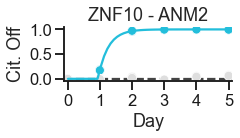

In [12]:
fig, ax = plt.subplots(figsize=(3, 1))

plasmid = 76

def make_lineplot(ax, plasmid):
    xdf = pdf[pdf['plasmid'].isin([plasmid, 126])]
    xdf = xdf[xdf['treatment']=='none']

    ax.axhline(y = 0, color = '#444444', linestyle = '--', zorder = 0)

    pal = ["#23bedb", "#DEDEDE"] if plasmid != 126 else ["#DEDEDE"]
    if plasmid >= 126:
        pal = pal[::-1]
    
    sns.scatterplot(
        data = xdf,
        x = 'day',
        y = 'norm cit off',
        hue = 'description',
        palette = pal,
        legend = False,
        ax = ax
    )
#     sns.lineplot(
#         data = xdf,
#         ci = None,
#         x = 'day',
#         y = 'norm cit off',
#         hue = 'plasmid',
#         palette = pal,
#         legend = False,
#         ax = ax
#     )
    
    def sil_curve(t, kS, tLag1):
        return 0.0*(t<tLag1) + (1-np.exp(-1*kS*(t-tLag1)))*(t>=tLag1)
        
    xvalues = list(xdf[xdf['plasmid']==plasmid].dropna(subset=['norm cit off'])['day'])
    yvalues = list(xdf[xdf['plasmid']==plasmid].dropna(subset=['norm cit off'])['norm cit off'])
    popt, pcov = curve_fit(sil_curve, xvalues, yvalues)
    fit_x = list(np.linspace(0.01, 5))
    fit_y = sil_curve(fit_x, *popt) 
    ax.plot(fit_x, fit_y, color = '#23bedb')

    ax.set_xlim(-0.1, 5.1)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.5, 1])
    
    ax.set_title(plasmid_dict[plasmid])
    
    ax.set_xlabel('Day')
    ax.set_ylabel('Cit. Off')
    #ax.legend(title='', markerscale=1.0)
    
    sns.despine(ax=ax)
    
    return popt
    
make_lineplot(ax, plasmid)

# Making line plots

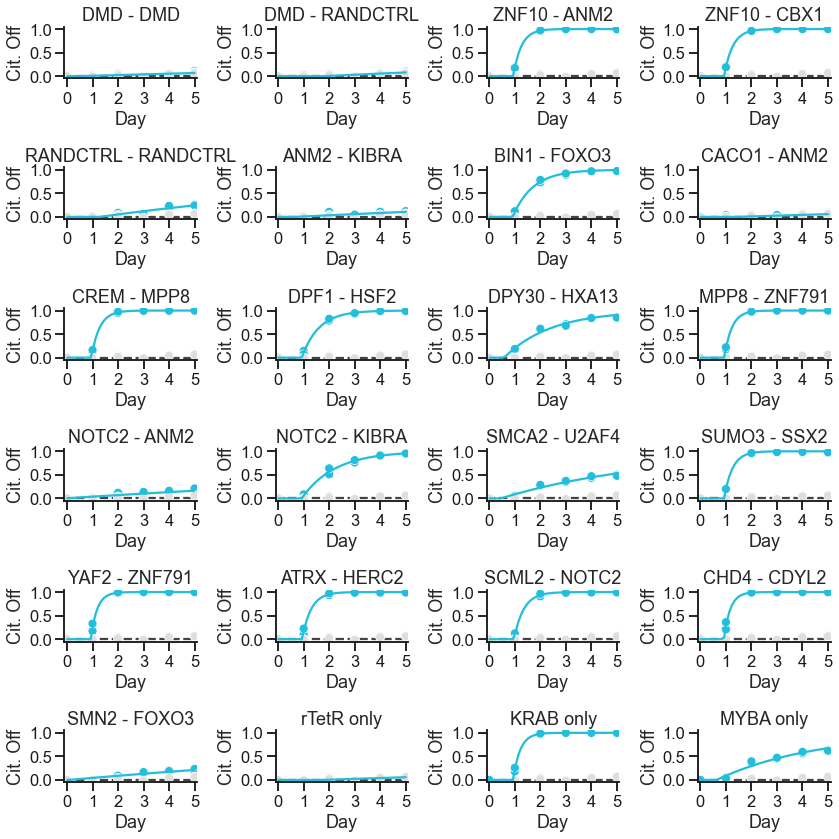

In [21]:
fig, ax = plt.subplots(6, 4, figsize=(12, 12))

plasmid_arr = [[plasmids[4*i + j] for j in range(4)] for i in range(6)]

popt_dict = { p : [] for p in plasmids }

for i in range(len(plasmid_arr)):
    for j in range(len(plasmid_arr[i])):
        popt_dict[plasmid_arr[i][j]] = make_lineplot(ax[i][j], plasmid_arr[i][j])

plt.tight_layout()

fig.savefig('./repressors_d5_omnibus.png', dpi = 300)
fig.savefig('./repressors_d5_omnibus.pdf', bbox_inches = 'tight')

In [23]:
for plasmid in plasmids:
    fig, ax = plt.subplots(figsize=(3, 1))
    
    descr = plasmid_dict[plasmid]
    popt = make_lineplot(ax, plasmid)
    
    fig.savefig('./lineplots/' + descr + ' Silencing.pdf', bbox_inches = 'tight')
    print(descr)
    plt.close(fig)

DMD - DMD
DMD - RANDCTRL
ZNF10 - ANM2
ZNF10 - CBX1
RANDCTRL - RANDCTRL
ANM2 - KIBRA
BIN1 - FOXO3
CACO1 - ANM2
CREM - MPP8
DPF1 - HSF2
DPY30 - HXA13
MPP8 - ZNF791
NOTC2 - ANM2
NOTC2 - KIBRA
SMCA2 - U2AF4
SUMO3 - SSX2
YAF2 - ZNF791
ATRX - HERC2
SCML2 - NOTC2
CHD4 - CDYL2
SMN2 - FOXO3
rTetR only
KRAB only
MYBA only


# Correlation with screen data

In [24]:
qdf = pd.DataFrame.from_dict({
    'plasmid' : plasmids,
    'description' : [plasmid_dict[p] for p in plasmids],
    'ks' : [popt_dict[p][0] for p in plasmids],
    'tlag' : [popt_dict[p][1] for p in plasmids]
})

qdf = qdf[qdf['plasmid'] < 126]

In [27]:
screen_data = pd.read_csv('../../01_repressor_additivity/pairs_baselinesums.csv')
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,2.054285,0.493242,Repressor,Non-hit,A-N,Other,True,False,1.126839,2.462512
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,0.351655,0.582309,Repressor,Activator,A-A,Activator,True,True,5.959180,0.703310
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,-0.808308,0.670493,Repressor,Repressor,R-R,Repressor,False,True,-3.901673,-1.616616
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,0.745666,0.626952,Activator,Activator,A-A,Activator,True,True,5.391484,1.491332
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,1.827117,0.364559,Repressor,Non-hit,R-N,Other,False,True,-3.468438,-1.219896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.449007,0.414017,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.146319,-2.566018
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.750528,0.642879,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.969341,-1.916518
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.750528,0.642879,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.913868,-2.867540
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.281728,0.818380,Activator,Non-hit,C-N,Other,NaN,NaN,-2.354220,3.115738


In [28]:
descrs = list(qdf['description'])
splits = [d.split(' ') for d in descrs]
d1s = [s[0] for s in splits]
d2s = [s[2] for s in splits]

qdf['domain1'] = d1s
qdf['domain2'] = d2s

qdf

,plasmid,description,ks,tlag,domain1,domain2
0,74,DMD - DMD,0.015429,0.537230,DMD,DMD
1,75,DMD - RANDCTRL,0.025537,1.805088,DMD,RANDCTRL
2,76,ZNF10 - ANM2,3.178141,0.938369,ZNF10,ANM2
3,77,ZNF10 - CBX1,2.959320,0.926428,ZNF10,CBX1
4,78,RANDCTRL - RANDCTRL,0.075796,1.294637,RANDCTRL,RANDCTRL
5,79,ANM2 - KIBRA,0.026153,0.668837,ANM2,KIBRA
6,80,BIN1 - FOXO3,1.253312,0.913140,BIN1,FOXO3
7,81,CACO1 - ANM2,0.016807,1.395714,CACO1,ANM2
8,82,CREM - MPP8,3.088496,0.950128,CREM,MPP8
9,83,DPF1 - HSF2,1.481085,0.922303,DPF1,HSF2


In [31]:
screen_data_d1 = list(screen_data['d1_Gene'])
screen_data_d2 = list(screen_data['d2_Gene'])
screen_data['description'] = [str(s1) + ' - ' + str(s2) for s1, s2 in zip(screen_data_d1, screen_data_d2)]
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5,description
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,0.493242,Repressor,Non-hit,A-N,Other,True,False,1.126839,2.462512,NCOA2 - TET2
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,0.582309,Repressor,Activator,A-A,Activator,True,True,5.959180,0.703310,SERTAD2 - SERTAD2
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,0.670493,Repressor,Repressor,R-R,Repressor,False,True,-3.901673,-1.616616,HES2 - HES2
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,0.626952,Activator,Activator,A-A,Activator,True,True,5.391484,1.491332,ZN473 - ZN473
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,0.364559,Repressor,Non-hit,R-N,Other,False,True,-3.468438,-1.219896,HERC2 - ADRM1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.414017,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.146319,-2.566018,nan - CBX7
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.642879,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.969341,-1.916518,DMD - CBX1
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.642879,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.913868,-2.867540,nan - CBX1
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.818380,Activator,Non-hit,C-N,Other,NaN,NaN,-2.354220,3.115738,DMD - CXXC1


In [32]:
mdf = qdf.set_index('description').join(
    screen_data.set_index('description'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()
mdf = mdf[mdf['character'] != 'Control']
mdf = mdf[mdf['description'] != 'DMD - DMD']
mdf = mdf[mdf['description'] != 'DMD - RANDCTRL']
mdf

,description,plasmid,ks,tlag,domain1,domain2,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,...,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,ANM2 - KIBRA,79,0.026153,0.668837,ANM2,KIBRA,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45 --...,0 control Pair,4.416198,1.958100,...,1.018976,0.882401,Activator,Activator,A-A,Activator,True,False,1.468227,2.807424
1,ATRX - HERC2,96,2.866741,0.939224,ATRX,HERC2,Silencer_tiles;ENSG00000085224;242 --- Short_n...,0 control Pair,-2.239736,-2.232381,...,-3.047013,0.726130,Repressor,Repressor,N-R,Other,False,True,-3.735716,-1.209324
2,BIN1 - FOXO3,80,1.253312,0.913140,BIN1,FOXO3,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63 -...,0 control Pair,2.926735,-1.220991,...,0.111979,0.639032,Activator,Activator,N-A,Other,True,True,1.652464,0.973390
3,CACO1 - ANM2,81,0.016807,1.395714,CACO1,ANM2,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,0 control Pair,4.309588,1.814068,...,1.788448,0.450569,Activator,Activator,A-A,Activator,True,False,-0.510206,3.103688
4,CHD4 - CDYL2,98,4.004496,0.916357,CHD4,CDYL2,Silencer_tiles;ENSG00000111642;38 --- Short_nu...,0 control Pair,-2.488804,-3.879202,...,-3.350849,0.825153,Repressor,Repressor,R-R,Repressor,False,True,-4.414195,-5.701481
5,CREM - MPP8,82,3.088496,0.950128,CREM,MPP8,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45 ...,0 control Pair,-1.755332,-3.464165,...,-2.822486,1.093412,Repressor,Repressor,R-R,Repressor,False,True,-4.930051,-3.492127
105,DPF1 - HSF2,83,1.481085,0.922303,DPF1,HSF2,Short_nuclear_domain;DPF1_HUMAN;Requiem_N;34;7...,0 control Pair,-6.253982,1.292979,...,-2.197255,0.920288,Repressor,Repressor,N-R,Other,False,False,-3.705778,0.346046
106,DPY30 - HXA13,84,0.538440,0.579185,DPY30,HXA13,Short_nuclear_domain;DPY30_HUMAN;Dpy-30;19;41 ...,0 control Pair,NaN,NaN,...,0.253853,1.056561,Repressor,Non-hit,N-N,Other,NaN,NaN,-3.821164,2.660404
107,MPP8 - ZNF791,87,3.403814,0.934646,MPP8,ZNF791,Short_nuclear_domain;MPP8_HUMAN;Chromo;44;50 -...,0 control Pair,-5.147067,-3.181765,...,-3.202350,0.786646,Repressor,Repressor,R-R,Repressor,NaN,True,-5.317202,-6.024836
108,NOTC2 - ANM2,90,0.035116,-0.097437,NOTC2,ANM2,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34...,0 control Pair,4.309706,1.934292,...,1.788448,0.450569,Activator,Activator,A-A,Activator,True,False,0.225259,2.744243


In [33]:
# manually add back the controls

cdf = qdf[qdf['description'].isin(['DMD - DMD', 'DMD - RANDCTRL', 'RANDCTRL - RANDCTRL'])]
cdf

,plasmid,description,ks,tlag,domain1,domain2
0,74,DMD - DMD,0.015429,0.537230,DMD,DMD
1,75,DMD - RANDCTRL,0.025537,1.805088,DMD,RANDCTRL
4,78,RANDCTRL - RANDCTRL,0.075796,1.294637,RANDCTRL,RANDCTRL


In [34]:
cdict = {
    "DMD - DMD" : "DMD_control_tiles;ENSG00000198947;;131; -  DMD_control_tiles;ENSG00000198947;;297;",
    "DMD - RANDCTRL" : "DMD_control_tiles;ENSG00000198947;;297; - Random_control;;;21;",
    "RANDCTRL - RANDCTRL" : "Random_control;;;205; - Random_control;;;410;"
}

cdf['description+'] = [cdict[d] for d in list(cdf['description'])]
cdf

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_12158/681205518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,plasmid,description,ks,tlag,domain1,domain2,description+
0,74,DMD - DMD,0.015429,0.537230,DMD,DMD,DMD_control_tiles;ENSG00000198947;;131; - DMD...
1,75,DMD - RANDCTRL,0.025537,1.805088,DMD,RANDCTRL,DMD_control_tiles;ENSG00000198947;;297; - Rand...
4,78,RANDCTRL - RANDCTRL,0.075796,1.294637,RANDCTRL,RANDCTRL,Random_control;;;205; - Random_control;;;410;


In [35]:
screen_data_d1 = list(screen_data['domain1'])
screen_data_d2 = list(screen_data['domain2'])
screen_data['description+'] = [s1 + ' - ' + s2 for s1, s2 in zip(screen_data_d1, screen_data_d2)]
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5,description,description+
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,Repressor,Non-hit,A-N,Other,True,False,1.126839,2.462512,NCOA2 - TET2,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,Repressor,Activator,A-A,Activator,True,True,5.959180,0.703310,SERTAD2 - SERTAD2,Silencer_tiles;ENSG00000179833;22 - Silencer_t...
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,Repressor,Repressor,R-R,Repressor,False,True,-3.901673,-1.616616,HES2 - HES2,Silencer_tiles;ENSG00000069812;10 - Silencer_t...
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,Activator,Activator,A-A,Activator,True,True,5.391484,1.491332,ZN473 - ZN473,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 - S...
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,Repressor,Non-hit,R-N,Other,False,True,-3.468438,-1.219896,HERC2 - ADRM1,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.146319,-2.566018,nan - CBX7,Random_control;;;21; - Silencer_tiles;ENSG0000...
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.969341,-1.916518,DMD - CBX1,DMD_control_tiles;ENSG00000198947;;255; - Shor...
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Repressor,Repressor,C-R,Repressor,NaN,NaN,-3.913868,-2.867540,nan - CBX1,Random_control;;;21; - Short_nuclear_domain;CB...
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Activator,Non-hit,C-N,Other,NaN,NaN,-2.354220,3.115738,DMD - CXXC1,DMD_control_tiles;ENSG00000198947;;255; - Shor...


In [36]:
ccdf = cdf.set_index('description+').join(
    screen_data.set_index('description+'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()
ccdf = ccdf.drop(['description+'], axis=1)
ccdf

,plasmid,description,ks,tlag,domain1,domain2,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,...,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5,description_screen
0,74,DMD - DMD,0.015429,0.537230,DMD,DMD,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75,DMD - RANDCTRL,0.025537,1.805088,DMD,RANDCTRL,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,2 control Pair,-1.657747,1.840322,...,1.669026,Control,Control,C-C,Control,False,False,NaN,NaN,DMD - nan
2,78,RANDCTRL - RANDCTRL,0.075796,1.294637,RANDCTRL,RANDCTRL,Random_control;;;205; --- Random_control;;;410;,2 control Pair,-1.120361,1.508892,...,1.717955,Control,Control,C-C,Control,False,False,-2.929481,0.671557,nan - nan


In [37]:
zdf = pd.concat([mdf, ccdf])
zdf.sort_values(by='plasmid')

,description,plasmid,ks,tlag,domain1,domain2,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,...,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5,description_screen
0,DMD - DMD,74,0.015429,0.537230,DMD,DMD,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DMD - RANDCTRL,75,0.025537,1.805088,DMD,RANDCTRL,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,2 control Pair,-1.657747,1.840322,...,1.669026,Control,Control,C-C,Control,False,False,NaN,NaN,DMD - nan
116,ZNF10 - ANM2,76,3.178141,0.938369,ZNF10,ANM2,Human_KRAB_variant;P21506;146 --- Short_nuclea...,0 control Pair,-3.060923,-4.044540,...,0.450569,Activator,Activator,R-A,Both,False,True,-2.290708,-1.310415,NaN
117,ZNF10 - CBX1,77,2.959320,0.926428,ZNF10,CBX1,Human_KRAB_variant;P21506;146 --- Short_nuclea...,0 control Pair,-2.264251,0.231829,...,0.642879,Repressor,Repressor,R-R,Repressor,False,True,-5.247002,-5.849392,NaN
2,RANDCTRL - RANDCTRL,78,0.075796,1.294637,RANDCTRL,RANDCTRL,Random_control;;;205; --- Random_control;;;410;,2 control Pair,-1.120361,1.508892,...,1.717955,Control,Control,C-C,Control,False,False,-2.929481,0.671557,nan - nan
110,RANDCTRL - RANDCTRL,78,0.075796,1.294637,RANDCTRL,RANDCTRL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ANM2 - KIBRA,79,0.026153,0.668837,ANM2,KIBRA,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45 --...,0 control Pair,4.416198,1.958100,...,0.882401,Activator,Activator,A-A,Activator,True,False,1.468227,2.807424,NaN
2,BIN1 - FOXO3,80,1.253312,0.913140,BIN1,FOXO3,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63 -...,0 control Pair,2.926735,-1.220991,...,0.639032,Activator,Activator,N-A,Other,True,True,1.652464,0.973390,NaN
3,CACO1 - ANM2,81,0.016807,1.395714,CACO1,ANM2,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,0 control Pair,4.309588,1.814068,...,0.450569,Activator,Activator,A-A,Activator,True,False,-0.510206,3.103688,NaN
5,CREM - MPP8,82,3.088496,0.950128,CREM,MPP8,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45 ...,0 control Pair,-1.755332,-3.464165,...,1.093412,Repressor,Repressor,R-R,Repressor,False,True,-4.930051,-3.492127,NaN


In [44]:
zdf = zdf.dropna(subset=['character'])
# print(list(set(list(zdf['character']))))
zdf = zdf.set_index('character').loc[
    ["Control", "Activator", "Repressor", "Both", "Other"]
].reset_index()
zdf.head()

,character,description,plasmid,ks,tlag,domain1,domain2,pair,type,enrichment_ratio_r1_d2,...,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5,description_screen
0,Control,DMD - RANDCTRL,75,0.025537,1.805088,DMD,RANDCTRL,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,2 control Pair,-1.657747,...,-0.117011,1.669026,Control,Control,C-C,False,False,NaN,NaN,DMD - nan
1,Control,RANDCTRL - RANDCTRL,78,0.075796,1.294637,RANDCTRL,RANDCTRL,Random_control;;;205; --- Random_control;;;410;,2 control Pair,-1.120361,...,0.732395,1.717955,Control,Control,C-C,False,False,-2.929481,0.671557,nan - nan
2,Activator,ANM2 - KIBRA,79,0.026153,0.668837,ANM2,KIBRA,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45 --...,0 control Pair,4.416198,...,1.018976,0.882401,Activator,Activator,A-A,True,False,1.468227,2.807424,NaN
3,Activator,CACO1 - ANM2,81,0.016807,1.395714,CACO1,ANM2,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,0 control Pair,4.309588,...,1.788448,0.450569,Activator,Activator,A-A,True,False,-0.510206,3.103688,NaN
4,Activator,NOTC2 - ANM2,90,0.035116,-0.097437,NOTC2,ANM2,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34...,0 control Pair,4.309706,...,1.788448,0.450569,Activator,Activator,A-A,True,False,0.225259,2.744243,NaN


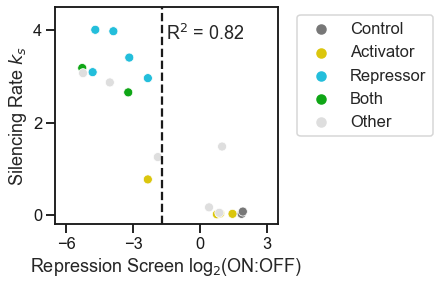

In [46]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    data = zdf.dropna(subset=['character']),
    x = 'avg_enrichment_d5',
    y = 'ks',
    hue = 'character',
    palette = ['#777777', '#dbc60d', '#23bedb', "#0fa616", "#dedede"],
    ax=ax
)

ax.axvline(-1.713, color='k', linestyle='--')

ldf = zdf.dropna(subset=['character', 'avg_enrichment_d5', 'ks'])
#ldf = ldf[ldf['avg_enrichment_d5'] < -1.713]
m, b = np.polyfit(ldf['avg_enrichment_d5'], ldf['ks'], 1)
xvals = np.linspace(-6.5, 3.5)
yvals = [m*x + b for x in xvals]
# ax.plot(xvals, yvals, color = "#DDDDDD", zorder=0)
r, p = st.pearsonr(ldf['avg_enrichment_d5'], ldf['ks'])
ax.text(-1.5, 3.8, "R$^2$ = {:.2f}".format(r**2))

# # fit line to actual data
# ldf = zdf.dropna(subset=['character'])
# ldf = ldf[ldf['avg_enrichment_d5'] <= -1.713]
# #m, b = np.polyfit(ldf['avg_enrichment_d5'], ldf['ks'], 1)
# r, p = st.pearsonr(ldf['avg_enrichment_d5'], ldf['ks'])
# ax.text(1.5, 0, "R$^2$ = {:.2f}".format(r**2))

# xvals = np.linspace(-6.5, 3.5)
# yvals = [m*x + b for x in xvals]
# #ax.plot(xvals, yvals, color='#DDDDDD', zorder=0)

ax.set_xlim(-6.5, 3.5)
ax.set_xticks([-6, -3, 0, 3])
ax.set_ylim(-0.2, 4.5)
ax.set_yticks([0, 2, 4])

ax.legend(title='', markerscale=1.0, bbox_to_anchor = (1.05, 1))

ax.set_xlabel('Repression Screen log$_2$(ON:OFF)')
ax.set_ylabel('Silencing Rate $k_s$')

#plt.tight_layout()

fig.savefig('./repressor_sil_correlation.pdf', bbox_inches = 'tight')
fig.savefig('./repressor_sil_correlation.png', dpi = 300)

# Correlating with Activation Data

In [60]:
act_data = pd.read_csv('../../../fig_2/02_activator_validations/data/mfi_data.csv')
#                        2021.11.15_activation_round1/activation_data.csv')
print(list(act_data.columns))
act_data = act_data[act_data['date']=='2021/11/15']
act_data

['plasmid', 'date', 'f_on', 'mfi']


,plasmid,date,f_on,mfi
0,72,2021/11/15,0.006702,2.011207e+06
1,74,2021/11/15,0.003631,1.856576e+06
2,75,2021/11/15,0.004688,1.938274e+06
3,76,2021/11/15,0.004189,1.936726e+06
4,77,2021/11/15,0.008212,1.970860e+06
5,78,2021/11/15,0.009423,2.039563e+06
7,79,2021/11/15,0.954545,2.661060e+08
9,80,2021/11/15,0.663269,5.698616e+07
11,81,2021/11/15,0.936408,2.603357e+08
12,82,2021/11/15,0.005296,1.911655e+06


In [63]:
vdf = zdf.set_index('plasmid').join(
    act_data.set_index('plasmid'),
    on = 'plasmid',
    how = 'left',
    rsuffix = '_act'
).reset_index()
vdf = vdf[['description', 'plasmid', 'ks', 'tlag', 'f_on', 'character']]
vdf['Citrine On'] = vdf['f_on']
vdf = vdf.drop('f_on', axis=1)
vdf['character'] = list(vdf['character'])[0:18] + ['Control'] + list(vdf['character'])[19:]
vdf

,description,plasmid,ks,tlag,character,Citrine On
0,DMD - RANDCTRL,75,0.025537,1.805088,Control,0.004688
1,RANDCTRL - RANDCTRL,78,0.075796,1.294637,Control,0.009423
2,ANM2 - KIBRA,79,0.026153,0.668837,Activator,0.954545
3,CACO1 - ANM2,81,0.016807,1.395714,Activator,0.936408
4,NOTC2 - ANM2,90,0.035116,-0.097437,Activator,0.931183
5,NOTC2 - KIBRA,91,0.770373,0.921121,Activator,0.265491
6,CHD4 - CDYL2,98,4.004496,0.916357,Repressor,0.004142
7,CREM - MPP8,82,3.088496,0.950128,Repressor,0.005296
8,MPP8 - ZNF791,87,3.403814,0.934646,Repressor,0.004101
9,YAF2 - ZNF791,94,3.973450,0.927227,Repressor,0.002503


In [65]:
char_text_map = {
    'Activator' : 'C-A, A-C, A-A',
    'Repressor' : 'C-R, R-C, R-R',
    'Both'      : 'A-R, R-A',
    'Control'   : 'C-C',
    'Other'     : 'Other'
}

vdf['character_map'] = [char_text_map[c] for c in list(vdf['character'])]
vdf

,description,plasmid,ks,tlag,character,Citrine On,character_map
0,DMD - RANDCTRL,75,0.025537,1.805088,Control,0.004688,C-C
1,RANDCTRL - RANDCTRL,78,0.075796,1.294637,Control,0.009423,C-C
2,ANM2 - KIBRA,79,0.026153,0.668837,Activator,0.954545,"C-A, A-C, A-A"
3,CACO1 - ANM2,81,0.016807,1.395714,Activator,0.936408,"C-A, A-C, A-A"
4,NOTC2 - ANM2,90,0.035116,-0.097437,Activator,0.931183,"C-A, A-C, A-A"
5,NOTC2 - KIBRA,91,0.770373,0.921121,Activator,0.265491,"C-A, A-C, A-A"
6,CHD4 - CDYL2,98,4.004496,0.916357,Repressor,0.004142,"C-R, R-C, R-R"
7,CREM - MPP8,82,3.088496,0.950128,Repressor,0.005296,"C-R, R-C, R-R"
8,MPP8 - ZNF791,87,3.403814,0.934646,Repressor,0.004101,"C-R, R-C, R-R"
9,YAF2 - ZNF791,94,3.973450,0.927227,Repressor,0.002503,"C-R, R-C, R-R"


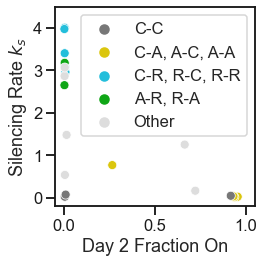

In [66]:
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(
    data = vdf,
    x = 'Citrine On',
    y = 'ks',
    hue = 'character_map',
    palette = ['#777777', '#dbc60d', '#23bedb', "#0fa616", "#dddddd"],
    ax = ax
)

ax.legend(title='', markerscale=1.0)#, bbox_to_anchor = (1.7, 1.1))
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.2, 4.5)

ax.set_xlabel('Day 2 Fraction On')
ax.set_ylabel('Silencing Rate $k_s$')

plt.tight_layout()
fig.savefig('./activation_ks_correlation.pdf', bbox_inches = 'tight')

In [67]:
vdf.to_csv("./data/paramed_concats.csv", index = False)

# Some Distributions

<AxesSubplot:xlabel='mCitrine-A', ylabel='Density'>

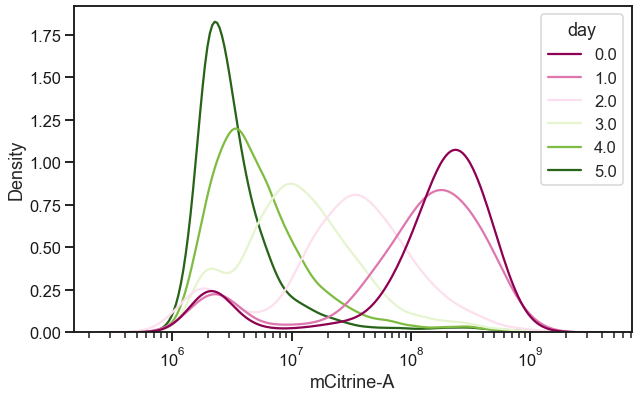

In [68]:
bfdf = df[df['description'].str.contains('BIN1')]
bfdf

sns.kdeplot(
    data = bfdf[bfdf['dox']==1000],
    x = 'mCitrine-A',
    hue = 'day',
    palette = 'PiYG',
    log_scale = True,
    common_norm = False
)